# Modeling – Telco Customer Churn

In this notebook we turn the EDA insights into a predictive model.

Steps:

1. Load and clean the data using the same functions as in the EDA notebook.
2. Add additional engineered features (e.g. number of services, billing flags).
3. Split the data into training and test sets.
4. Build a preprocessing pipeline (scaling + one-hot encoding).
5. Train and tune several models:
   - Logistic Regression (baseline),
   - Random Forest,
   - HistGradientBoosting,
   - PyTorch MLP.
6. Compare model performance using ROC-AUC and other metrics.
7. Adjust the decision threshold for the best model to reflect business needs.
Train and evaluate baseline and advanced models to predict churn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)

from src.data.make_dataset import load_and_clean_churn_data
from src.features.build_features import add_churn_features

In [2]:
def plot_confusion_matrix_pretty(y_true, y_pred, title="Confusion matrix"):
    labels = ["No churn", "Churn"]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [3]:
# General
TEST_SIZE = 0.2
RANDOM_STATE = 42
TARGET_COL = "Churn"

# Logistic Regression search space
LOGREG_PARAM_DISTS = {
    "clf__C": np.logspace(-3, 2, 30),
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs"],
}

# Random Forest base hyperparams
RF_BASE_PARAMS = {
    "n_estimators": 300,
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
}

# Random Forest search space
RF_PARAM_DISTS = {
    "clf__n_estimators": [200, 300, 500, 800],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": [None, "balanced"],
}

# Gradient Boosting (sklearn's HistGradientBoostingClassifier)
HGB_PARAM_DISTS = {
    "clf__max_depth": [3, None],
    "clf__learning_rate": [0.02, 0.05, 0.1],
    "clf__max_iter": [200, 400],
    "clf__l2_regularization": [0.0, 1.0, 5.0],
}


## 1. Preprocessing pipeline

To avoid data leakage and keep things reproducible, we use a scikit-learn
`ColumnTransformer` and `Pipeline`:

- Numeric features are scaled using `StandardScaler`.
- Categorical features are one-hot encoded with `OneHotEncoder`.
- The preprocessor is then combined with each classifier (Logistic Regression, Random Forest, etc.) into a single pipeline.

This ensures that the same preprocessing steps are applied consistently during cross-validation and on the test set.


In [4]:

def train_test_split_xy(df: pd.DataFrame):
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]

    return train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y,
    )


def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ]
    )


def build_logreg_pipeline(X: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X)
    clf = LogisticRegression(max_iter=1000)  # tuned via LOGREG_PARAM_DISTS
    return Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])


def build_rf_pipeline(X: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X)
    clf = RandomForestClassifier(**RF_BASE_PARAMS)
    return Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])


def build_hgb_pipeline(X: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X)
    clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    return Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])


def run_random_search(
    pipe: Pipeline,
    param_distributions: dict,
    X_train,
    y_train,
    n_iter: int = 25,
    scoring: str = "roc_auc",
):
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
    )
    search.fit(X_train, y_train)
    print("Best params:", search.best_params_)
    print("Best CV score:", search.best_score_)
    return search.best_estimator_


## 2. Load data and compute engineered features

We reuse the same core functions as in the EDA notebook:

- `load_and_clean_churn_data` (from `src.data.make_dataset`)  
- `add_churn_features` (from `src.features.build_features`)

The engineered features include, for example:

- number of services a customer uses,
- charges per month over their lifetime,
- flags for fiber optic, electronic check, paperless billing, etc.

This keeps the feature logic in one place, so we can reuse it later if we deploy the model.


In [5]:
df = load_and_clean_churn_data()
df = add_churn_features(df)
X_train, X_test, y_train, y_test = train_test_split_xy(df)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_services,tenure_bucket,charges_per_month_lifetime,has_fiber_optic,is_electronic_check,is_paperless
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Electronic check,29.85,29.85,0,1,0-1y,29.850000,0,1,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,Mailed check,56.95,1889.50,0,3,2-4y,55.573529,0,0,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Mailed check,53.85,108.15,1,3,0-1y,54.075000,0,0,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Bank transfer (automatic),42.30,1840.75,0,3,2-4y,40.905556,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Electronic check,70.70,151.65,1,1,0-1y,75.825000,1,1,1


## 3. Logistic Regression (baseline, tuned)

We first train a **Logistic Regression** model as a baseline:

- It is interpretable and fast to train.
- We use `RandomizedSearchCV` to tune:
  - the regularization strength `C`,
  - the `class_weight` (to handle class imbalance),
  - other solver-related parameters.

We then evaluate it on the test set using ROC-AUC and a classification report.

In [6]:
logreg_pipe = build_logreg_pipeline(X_train)
best_logreg = run_random_search(
    logreg_pipe,
    LOGREG_PARAM_DISTS,
    X_train,
    y_train,
    n_iter=30,
)

y_proba_lr = best_logreg.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("=== Logistic Regression (tuned) ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': np.float64(1.2689610031679235)}
Best CV score: 0.8468190983666297
=== Logistic Regression (tuned) ===
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

ROC-AUC: 0.834696978324904


## 4. Tree-based models

Next we try non-linear models that can capture interactions between features:

- **Random Forest**
  - good baseline for tabular data,
  - robust, but can be less efficient for very large data.
- **HistGradientBoostingClassifier**
  - a gradient boosting algorithm optimized for tabular data,
  - often performs very well on structured datasets like this.

We again use `RandomizedSearchCV` to tune a small hyperparameter space for each model and evaluate them on the test set.


In [7]:
rf_pipe = build_rf_pipeline(X_train)
best_rf = run_random_search(
    rf_pipe,
    RF_PARAM_DISTS,
    X_train,
    y_train,
    n_iter=40,
)

y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print("=== Random Forest (tuned) ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'clf__n_estimators': 500, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}
Best CV score: 0.8468235522767579
=== Random Forest (tuned) ===
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.53      0.76      0.63       374

    accuracy                           0.76      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.76      0.77      1407

ROC-AUC: 0.8347176853668511


In [8]:
hgb_pipe = build_hgb_pipeline(X_train)
best_hgb = run_random_search(
    hgb_pipe,
    HGB_PARAM_DISTS,
    X_train,
    y_train,
    n_iter=25,
)

y_proba_hgb = best_hgb.predict_proba(X_test)[:, 1]
y_pred_hgb = (y_proba_hgb >= 0.5).astype(int)

print("=== HistGradientBoosting (tuned) ===")
print(classification_report(y_test, y_pred_hgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_hgb))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'clf__max_iter': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.02, 'clf__l2_regularization': 1.0}
Best CV score: 0.847514718148469
=== HistGradientBoosting (tuned) ===
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC: 0.8392149960397783


In [9]:
results = {
    "logreg": {
        "roc_auc": roc_auc_score(y_test, y_proba_lr),
    },
    "random_forest": {
        "roc_auc": roc_auc_score(y_test, y_proba_rf),
    },
    "hist_gradient_boosting": {
        "roc_auc": roc_auc_score(y_test, y_proba_hgb),
    },
}

results


{'logreg': {'roc_auc': 0.834696978324904},
 'random_forest': {'roc_auc': 0.8347176853668511},
 'hist_gradient_boosting': {'roc_auc': 0.8392149960397783}}

In [10]:
thresholds = np.linspace(0.2, 0.8, 13)

for t in thresholds:
    y_pred_t = (y_proba_hgb >= t).astype(int)
    print(
        f"Threshold {t:.2f} | "
        f"Precision: {precision_score(y_test, y_pred_t):.3f} | "
        f"Recall: {recall_score(y_test, y_pred_t):.3f}"
    )


Threshold 0.20 | Precision: 0.449 | Recall: 0.864
Threshold 0.25 | Precision: 0.477 | Recall: 0.821
Threshold 0.30 | Precision: 0.518 | Recall: 0.783
Threshold 0.35 | Precision: 0.565 | Recall: 0.719
Threshold 0.40 | Precision: 0.598 | Recall: 0.655
Threshold 0.45 | Precision: 0.623 | Recall: 0.583
Threshold 0.50 | Precision: 0.642 | Recall: 0.503
Threshold 0.55 | Precision: 0.665 | Recall: 0.425
Threshold 0.60 | Precision: 0.704 | Recall: 0.337
Threshold 0.65 | Precision: 0.767 | Recall: 0.246
Threshold 0.70 | Precision: 0.770 | Recall: 0.179
Threshold 0.75 | Precision: 0.918 | Recall: 0.120
Threshold 0.80 | Precision: 1.000 | Recall: 0.027


## 5. Neural network model (PyTorch MLP)

To experiment with a more flexible model, we also build a small fully-connected neural network (MLP) using PyTorch:

1. Use the same preprocessing pipeline to transform the data.
2. Convert the processed features to PyTorch tensors.
3. Train a simple MLP with:
   - a few hidden layers,
   - ReLU activations,
   - dropout for regularization.

The goal is **not** necessarily to beat tree-based models, but to show how the same features can be used in a deep learning pipeline.


In [11]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-3
HIDDEN_DIMS = [128, 64]
DROPOUT = 0.3

Using device: cpu


In [12]:
preprocessor_torch = build_preprocessor(X_train)

X_train_proc = preprocessor_torch.fit_transform(X_train)
X_test_proc = preprocessor_torch.transform(X_test)

# If the result is sparse, convert to dense
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

X_train_tensor = torch.from_numpy(X_train_proc.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_proc.astype(np.float32))

y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
class ChurnMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=None, dropout=0.0):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [128, 64]

        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # binary output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)  # logits (no sigmoid)

In [14]:
input_dim = X_train_proc.shape[1]
model = ChurnMLP(input_dim, HIDDEN_DIMS, DROPOUT).to(DEVICE)

# Handle class imbalance: pos_weight = (neg / pos)
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(pos_weight, dtype=torch.float32, device=DEVICE)
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_logits, all_targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits.cpu())
        all_targets.append(yb.cpu())
    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    return total_loss / len(loader.dataset), all_logits.numpy(), all_targets.numpy()

In [15]:
best_val_loss = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_logits, val_targets = eval_epoch(model, val_loader, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

# Load best weights
model.load_state_dict(best_state)

Epoch 01 | train_loss=0.9034 | val_loss=0.7812
Epoch 02 | train_loss=0.7554 | val_loss=0.7497
Epoch 03 | train_loss=0.7324 | val_loss=0.7370
Epoch 04 | train_loss=0.7203 | val_loss=0.7412
Epoch 05 | train_loss=0.7179 | val_loss=0.7351
Epoch 06 | train_loss=0.7135 | val_loss=0.7324
Epoch 07 | train_loss=0.7075 | val_loss=0.7333
Epoch 08 | train_loss=0.7114 | val_loss=0.7329
Epoch 09 | train_loss=0.7038 | val_loss=0.7345
Epoch 10 | train_loss=0.6944 | val_loss=0.7322
Epoch 11 | train_loss=0.6936 | val_loss=0.7346
Epoch 12 | train_loss=0.6951 | val_loss=0.7358
Epoch 13 | train_loss=0.6999 | val_loss=0.7334
Epoch 14 | train_loss=0.6976 | val_loss=0.7335
Epoch 15 | train_loss=0.6896 | val_loss=0.7362
Epoch 16 | train_loss=0.6871 | val_loss=0.7363
Epoch 17 | train_loss=0.6921 | val_loss=0.7357
Epoch 18 | train_loss=0.6854 | val_loss=0.7345
Epoch 19 | train_loss=0.6782 | val_loss=0.7396
Epoch 20 | train_loss=0.6804 | val_loss=0.7387
Epoch 21 | train_loss=0.6765 | val_loss=0.7377
Epoch 22 | tr

<All keys matched successfully>

In [16]:
from sklearn.metrics import roc_auc_score, classification_report

val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid
val_pred = (val_probs >= 0.5).astype(int)

print("=== PyTorch MLP ===")
print("ROC-AUC:", roc_auc_score(val_targets, val_probs))
print(classification_report(val_targets, val_pred))

=== PyTorch MLP ===
ROC-AUC: 0.8293390312210424
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79      1033
         1.0       0.49      0.77      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



## 6. Model comparison

We collect the main metrics for each model:

- ROC-AUC (our primary metric),
- accuracy,
- precision,
- recall,
- F1-score.

This allows us to compare:

- Logistic Regression (tuned),
- Random Forest (tuned),
- HistGradientBoosting (tuned),
- PyTorch MLP.

We will focus on ROC-AUC and the precision/recall trade-offs, because in churn prediction false negatives (missed churners) can be very costly.


In [17]:
def metrics_row(name, y_true, y_pred, y_proba):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

rows = []
rows.append(metrics_row("LogReg (tuned)", y_test, y_pred_lr, y_proba_lr))
rows.append(metrics_row("Random Forest (tuned)", y_test, y_pred_rf, y_proba_rf))
rows.append(metrics_row("HistGradientBoosting (tuned)", y_test, y_pred_hgb, y_proba_hgb))
rows.append(metrics_row("PyTorch MLP", val_targets, val_pred, val_probs))

metrics_df = pd.DataFrame(rows)
metrics_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg (tuned),0.793177,0.633441,0.526738,0.575182,0.834697
1,Random Forest (tuned),0.758351,0.531716,0.762032,0.626374,0.834718
2,HistGradientBoosting (tuned),0.793177,0.641638,0.502674,0.563718,0.839215
3,PyTorch MLP,0.727790,0.492308,0.770053,0.600626,0.829339


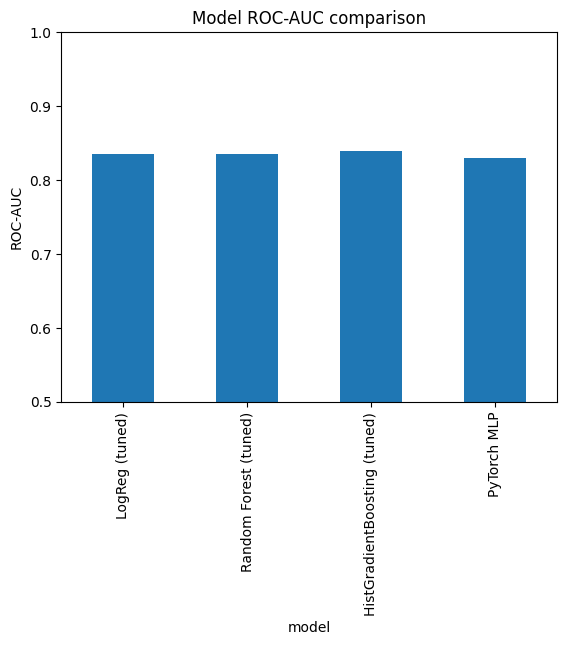

In [18]:
metrics_df.set_index("model")["roc_auc"].plot(kind="bar")
plt.ylim(0.5, 1.0)
plt.ylabel("ROC-AUC")
plt.title("Model ROC-AUC comparison")
plt.show()


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.2, 0.8, 13)
rows = []
for t in thresholds:
    y_pred_t = (y_proba_hgb >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t),
        "recall": recall_score(y_test, y_pred_t),
        "f1": f1_score(y_test, y_pred_t),
    })

thresh_df = pd.DataFrame(rows)
thresh_df

,threshold,precision,recall,f1
0,0.20,0.448611,0.863636,0.590494
1,0.25,0.477449,0.820856,0.603736
2,0.30,0.517668,0.783422,0.623404
3,0.35,0.565126,0.719251,0.632941
4,0.40,0.597561,0.655080,0.625000
5,0.45,0.622857,0.582888,0.602210
6,0.50,0.641638,0.502674,0.563718
7,0.55,0.665272,0.425134,0.518760
8,0.60,0.703911,0.336898,0.455696
9,0.65,0.766667,0.245989,0.372470


## 7. Threshold tuning for the best model

By default, classifiers predict "churn" when the estimated probability is ≥ 0.5.  
However, in churn prediction, we might prefer to:

- **Catch more churners** (higher recall), even if we get more false positives.
- Or **avoid too many false positives** if contacting customers is expensive.

We therefore:

1. Compute metrics for several probability thresholds.
2. Inspect how precision and recall change.
3. Choose a threshold that balances business needs (here we pick an example value).

This step is crucial to turn a good model into a practical business tool.


In [20]:
BEST_THRESHOLD = 0.20  # example, pick from the table

y_pred_hgb_best = (y_proba_hgb >= BEST_THRESHOLD).astype(int)

In [21]:
print("=== HistGradientBoosting @ threshold", BEST_THRESHOLD, "===")
print("Accuracy:", accuracy_score(y_test, y_pred_hgb_best))
print("Precision:", precision_score(y_test, y_pred_hgb_best))
print("Recall:", recall_score(y_test, y_pred_hgb_best))
print("F1:", f1_score(y_test, y_pred_hgb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_hgb))

=== HistGradientBoosting @ threshold 0.2 ===
Accuracy: 0.681592039800995
Precision: 0.4486111111111111
Recall: 0.8636363636363636
F1: 0.5904936014625228
ROC-AUC: 0.8392149960397783


In [22]:
def metrics_row(name, y_true, y_pred, y_proba):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

rows = []
rows.append(metrics_row("LogReg (tuned)", y_test, y_pred_lr, y_proba_lr))
rows.append(metrics_row("Random Forest (tuned)", y_test, y_pred_rf, y_proba_rf))
rows.append(metrics_row("HistGradientBoosting (tuned)", y_test, y_pred_hgb_best, y_proba_hgb))
rows.append(metrics_row("PyTorch MLP", val_targets, val_pred, val_probs))

metrics_df = pd.DataFrame(rows)
metrics_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg (tuned),0.793177,0.633441,0.526738,0.575182,0.834697
1,Random Forest (tuned),0.758351,0.531716,0.762032,0.626374,0.834718
2,HistGradientBoosting (tuned),0.681592,0.448611,0.863636,0.590494,0.839215
3,PyTorch MLP,0.727790,0.492308,0.770053,0.600626,0.829339


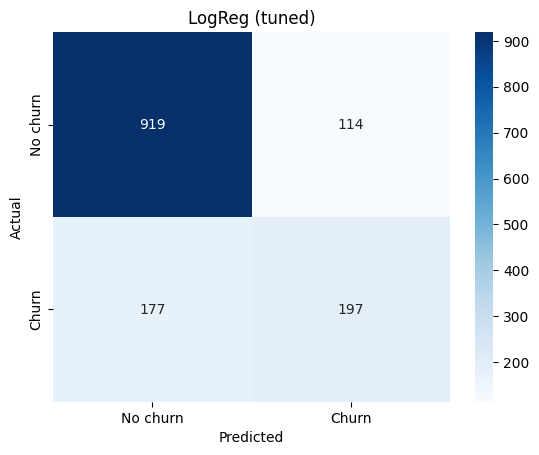

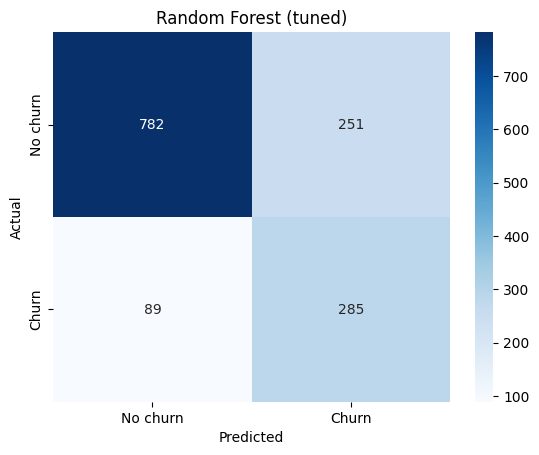

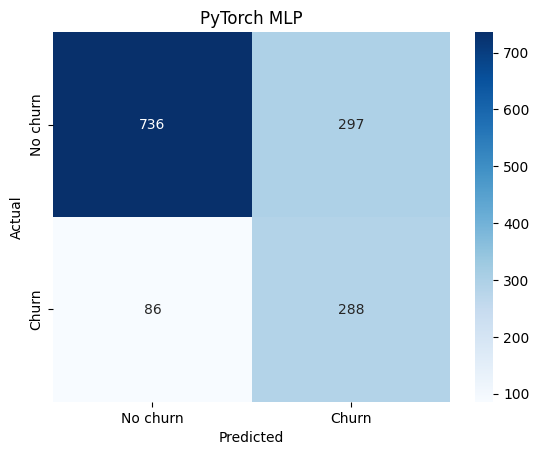

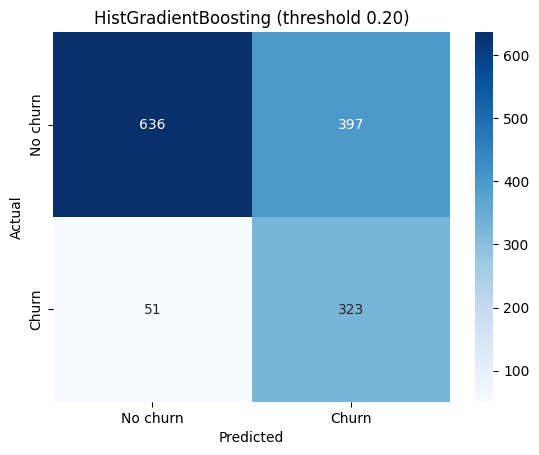

In [23]:
plot_confusion_matrix_pretty(y_test, y_pred_lr, title="LogReg (tuned)")
plot_confusion_matrix_pretty(y_test, y_pred_rf, title="Random Forest (tuned)")
plot_confusion_matrix_pretty(val_targets, val_pred, title="PyTorch MLP")
plot_confusion_matrix_pretty(
    y_test,
    y_pred_hgb_best,
    title=f"HistGradientBoosting (threshold {BEST_THRESHOLD:.2f})"
)

## 8. Conclusions

- Several models achieve good ROC-AUC scores on this dataset.
- Tree-based methods (especially HistGradientBoosting) perform strongly and handle non-linearities and interactions well.
- Logistic Regression remains a strong, interpretable baseline.
- The PyTorch MLP shows that deep learning can also be applied, but requires more tuning and careful regularization.
- Threshold tuning lets us adapt the model to different business scenarios:
  - higher recall if we care about catching as many churners as possible,
  - higher precision if we want to avoid contacting too many non-churners.

Next steps could include:

- adding cost-based evaluation (e.g. expected savings from retention campaigns),
- saving and loading models from the `models/` folder,
- building a simple API or app layer around the final model.
